# Roadmap

The goal of this notebook is to provide an example of how to scrape NEXRAD level II data and use pyart and csu_radar_tools to calculate radar rainfall estimates at rain gage locations during a storm.

  1. Genarate mock rain gage data
  2. Find available NEXRAD data
  2. Download NEXRAD data
  4. Mask bad data
  5. Download sounding data
  6. Classify hydrometeors
  7. Compute rainfall estimate
  8. Interpolate radially
  9. Pull out rainfall estimates at gage locations

Before getting started, set up your environment with all the necessities to run this notebook. To create this environment just run **`$ conda env create -f environment.yml`** where **`environment.yml`** is a file containing the following:

In [1]:
!cat environment.yml

name: radar
channels:
- conda-forge
- defaults
dependencies:
- python=2.7
- arm_pyart
- basemap
- basemap-data-hires
- matplotlib
- jupyter
- pandas
- numpy
- cython
- wget
- lxml
- pip:
  - skewt
  - git+git://github.com/CSU-Radarmet/CSU_RadarTools.git


## Mock rain gage data

In [2]:
import numpy as np
import pandas as pd
import xarray as xr

In [3]:
ID='KLWX'
latitude = 38.970
longitude = -77.473

year=2016
month=7
day=30
hour=22

t_start = '2016-07-30 22:00'
t_end = '2016-07-31 00:00'

In [4]:
%%time

netcdf=True

gage_times = pd.date_range(pd.datetime(year, month, day, hour), freq='15min', periods=10, tz='UTC')
gage_locs = np.random.rand(50,2)*2+ np.array([latitude, longitude])
gage_data = np.zeros((gage_times.shape[0], gage_locs.shape[0]))
gage_names = ['G'+str(i) for i in range(1, gage_locs.shape[0]+1)]

gage_df_data = pd.DataFrame(index=gage_times, data=gage_data, columns=gage_names)
gage_df_locs = pd.DataFrame(index=gage_names, data=gage_locs, columns=['lat', 'lon'])

if not netcdf:
    gage_df = pd.concat([gage_df_locs, gage_df_data.T], axis=1)
    gage_df.head()

def to_da(i, name, gage_data, gage_times):
    return xr.DataArray(gage_data[:,i], name=name, dims={'time': gage_times.shape},
                        coords={'time': gage_times.astype('datetime64[ns]'), 'station':name})

datasets = [to_da(i, name, gage_data, gage_times) for i, name in enumerate(gage_names)]
combined = xr.concat(datasets, 'station')
ds0 = combined.to_dataset(name='rain_gage_accumulation')

gage_df_locs.index.name='station'
ds_gage = ds0.merge(xr.Dataset(gage_df_locs))
ds_gage.set_coords(['lat', 'lon'], inplace=True)
print(ds_gage)

<xarray.Dataset>
Dimensions:                 (station: 50, time: 10)
Coordinates:
  * time                    (time) datetime64[ns] 2016-07-30T22:00:00 ...
  * station                 (station) |S3 'G1' 'G2' 'G3' 'G4' 'G5' 'G6' 'G7' ...
    lat                     (station) float64 39.38 40.89 39.05 40.84 40.87 ...
    lon                     (station) float64 -77.27 -75.49 -77.35 -77.14 ...
Data variables:
    rain_gage_accumulation  (station, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
CPU times: user 26.6 ms, sys: 4.03 ms, total: 30.7 ms
Wall time: 26.2 ms


## Find Available Data

First we will see what data are available for the date and site that we are interested in. 

In [5]:
Y = '{Y:04d}'.format(Y=year)
M = '{M:02d}'.format(M=month)
D = '{D:02d}'.format(D=day)

url = 'http://www.ncdc.noaa.gov/nexradinv/bdp-download.jsp?id={ID}&yyyy={Y}&mm={M}&dd={D}&product=AAL2'.format(
       ID=ID, Y=Y, M=M, D=D)

In [6]:
%%time
from lxml.html import parse

page = parse(url)
data_urls = [el.find("a").get("href") for el in page.xpath("//div[@class='bdpLink']")]
filenames = [data_url.split('/')[-1] for data_url in data_urls]
times = pd.DatetimeIndex([pd.Timestamp(fn[4:19].replace('_', ' ')) for fn in filenames])

CPU times: user 12 ms, sys: 7.87 ms, total: 19.8 ms
Wall time: 592 ms


In [7]:
t0 = times.asof(pd.Timestamp(t_start))
tn = times.asof(pd.Timestamp(t_end))

data_urls = data_urls[times.get_loc(t0): times.get_loc(tn)]
filenames = filenames[times.get_loc(t0): times.get_loc(tn)]

nscans = len(filenames)

## Download Data

Now that you have a valid data_url, all that is left is downloading the data.

In [8]:
%%time

def get_datafile(data_url, filename, cache='./tmp/'):
    import os
    import wget

    if not os.path.isdir(cache):
        os.mkdir(cache)

    if os.path.isfile(cache+filename):
        print('using cached file ...')
        path_to_file = cache+filename
    else:
        print('downloading file ...')
        path_to_file = wget.download(data_url, out=cache+filename)
    print(path_to_file)
    return path_to_file

CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 6.2 µs


In [9]:
%%time

if nscans > 100:
    print('Do you really intend to process >100 files?')
else:
    paths = []
    for data_url, filename in zip(data_urls, filenames):
        paths.append(get_datafile(data_url, filename))

downloading file ...
./tmp/KLWX20160730_215843_V06
downloading file ...
./tmp/KLWX20160730_220312_V06
downloading file ...
./tmp/KLWX20160730_220740_V06
downloading file ...
./tmp/KLWX20160730_221208_V06
downloading file ...
./tmp/KLWX20160730_221637_V06
downloading file ...
./tmp/KLWX20160730_222105_V06
downloading file ...
./tmp/KLWX20160730_222533_V06
downloading file ...
./tmp/KLWX20160730_223002_V06
downloading file ...
./tmp/KLWX20160730_223431_V06
downloading file ...
./tmp/KLWX20160730_223859_V06
downloading file ...
./tmp/KLWX20160730_224327_V06
downloading file ...
./tmp/KLWX20160730_224756_V06
downloading file ...
./tmp/KLWX20160730_225224_V06
downloading file ...
./tmp/KLWX20160730_225652_V06
downloading file ...
./tmp/KLWX20160730_230121_V06
downloading file ...
./tmp/KLWX20160730_230549_V06
downloading file ...
./tmp/KLWX20160730_231018_V06
downloading file ...
./tmp/KLWX20160730_231446_V06
downloading file ...
./tmp/KLWX20160730_231914_V06
downloading file ...
./tmp/KLWX

## Read data and calculate rainfall

In [10]:
import pyproj
import pyart
from skewt import SkewT
from csu_radartools import csu_fhc, csu_blended_rain, csu_dsd, csu_kdp

## Sounding

Optionally you can get data from a nearby sounding in the UWyo format (i.e., from http://weather.uwyo.edu/upperair/sounding.html), and copy and paste it into a txt file. 

In [11]:
sounding = SkewT.Sounding('./tmp/KLWX_2016-07-31_00_sounding.txt')

In [12]:
fields = ['interpolated_rain', 'interpolated_r_kdp', 'interpolated_r_z']
cols = ['gate_lon', 'gate_lat', 'gate_altitude']
cols.extend(fields)

## Run
First you need to run all the functions in the [last cell](#Functions), then you can process all the radar files

In [15]:
%%time
radar0 = pyart.io.read(paths[0])
netcdf=True
gage_dict={}
for gage_name in gage_names:
    if netcdf:
        latitude = ds_gage.lat.sel(station=gage_name).values
        longitude = ds_gage.lon.sel(station=gage_name).values
    else:
        latitude = gage_df.loc[gage_name, 'lat']
        longitude = gage_df.loc[gage_name, 'lon']
    x_disp, y_disp = find_x_y_displacement(radar0, longitude, latitude)
    gage_dict.update({gage_name: {'x_disp': x_disp, 'y_disp': y_disp}})

sweep_times = []
sweep_stacks = []
for path in paths:
    print('processing', path)
    radar = process_radar(path, sounding)
    base_time = pd.Timestamp(radar.time['units'].split()[2])
    for sweep in range(radar.nsweeps):
        end_sweep_time = pd.Timedelta(seconds=radar.time['data'][radar.get_end(sweep)])+base_time
        gate_x, gate_y, gate_z = radar.get_gate_x_y_z(sweep)
        sweep_times.append(end_sweep_time)
        
        b = []
        for gage_name in gage_names:
            distances = np.sqrt((gate_x-gage_dict[gage_name]['x_disp'])**2. + 
                                (gate_y-gage_dict[gage_name]['y_disp'])**2.)
            ray, gate = np.unravel_index(distances.argmin(), distances.shape)

            a = np.array([radar.gate_latitude['data'][ray, gate],
                          radar.gate_longitude['data'][ray, gate],
                          radar.gate_altitude['data'][ray, gate]])
            a = np.concatenate([a, [radar.fields[field]['data'][ray, gate] for field in fields]])
            b.append(a)
        sweep_stacks.append(np.stack(b, axis=1))
c = np.stack(sweep_stacks, axis=2)

d = {'time': {'dims': ('time'), 'data': sweep_times},
     'station': {'dims': ('station'), 'data': gage_names}}
for i, name in enumerate(cols):
    d.update({name: {'dims': ('station', 'time'), 'data': c[i]}})
ds_radar = xr.Dataset.from_dict(d)
ds_radar.set_coords(['gate_altitude', 'gate_lat', 'gate_lon'], inplace=True)

('processing', './tmp/KLWX20160730_215843_V06')
('processing', './tmp/KLWX20160730_220312_V06')
('processing', './tmp/KLWX20160730_220740_V06')
('processing', './tmp/KLWX20160730_221208_V06')
('processing', './tmp/KLWX20160730_221637_V06')
('processing', './tmp/KLWX20160730_222105_V06')
('processing', './tmp/KLWX20160730_222533_V06')
('processing', './tmp/KLWX20160730_223002_V06')
('processing', './tmp/KLWX20160730_223431_V06')
('processing', './tmp/KLWX20160730_223859_V06')
('processing', './tmp/KLWX20160730_224327_V06')
('processing', './tmp/KLWX20160730_224756_V06')
('processing', './tmp/KLWX20160730_225224_V06')
('processing', './tmp/KLWX20160730_225652_V06')
('processing', './tmp/KLWX20160730_230121_V06')
('processing', './tmp/KLWX20160730_230549_V06')
('processing', './tmp/KLWX20160730_231018_V06')
('processing', './tmp/KLWX20160730_231446_V06')
('processing', './tmp/KLWX20160730_231914_V06')
('processing', './tmp/KLWX20160730_232343_V06')
('processing', './tmp/KLWX20160730_23281

In [16]:
%%time
ds_radar_15 = ds_radar[fields].resample('15min', 'time', label='right')

CPU times: user 12.3 ms, sys: 1.01 ms, total: 13.3 ms
Wall time: 11.2 ms


In [17]:
%%time
ds = ds_gage.merge(ds_radar_15)

CPU times: user 992 µs, sys: 1 ms, total: 1.99 ms
Wall time: 1.66 ms


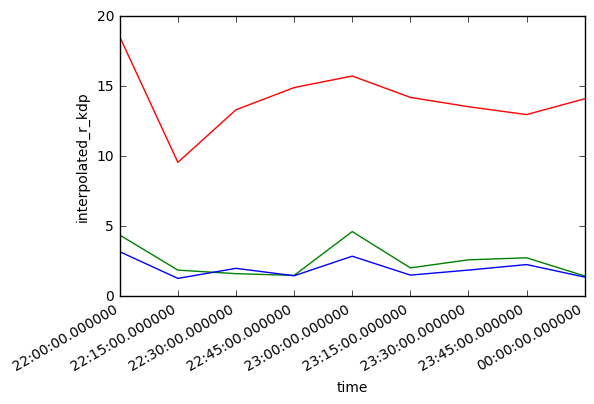

In [18]:
%matplotlib inline
ds.interpolated_rain.mean('station').plot(c='g')
ds.interpolated_r_z.mean('station').plot(c='b')
ds.interpolated_r_kdp.mean('station').plot(c='r');

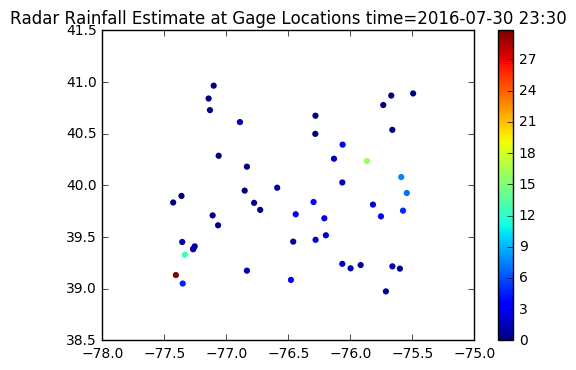

In [41]:
import matplotlib.pyplot as plt

t = '2016-07-30 23:30'
plt.scatter(ds.sel(time=t).lon,
            ds.sel(time=t).lat,
            c=ds.sel(time=t).interpolated_rain.values, edgecolor='None')
plt.colorbar()
plt.title('Radar Rainfall Estimate at Gage Locations time='+t);

## Functions
Run the cell below, then [hop back up](#Run) and process all the files.

In [14]:
def process_radar(path, sounding):
    radar = pyart.io.read(path)
    radar, start_gate, end_gate = mask_data(radar)
    dp_radar, vel_radar = separate_dp_vel_sweeps(radar)
    sw_vel_mask = construct_sw_vel_mask(vel_radar)
    radar = mask_dp_fiels(vel_radar, dp_radar, sw_vel_mask)
    calculate_rainfall(radar, sounding, start_gate, end_gate)
    return radar

def get_z_from_radar(radar):
    """Input radar object, return z from radar (m, 2D)"""
    zz = []
    for sweep in range(radar.nsweeps):
        zz.append(radar.get_gate_x_y_z(sweep)[2])
    return np.concatenate(zz, axis=0)

def check_sounding_for_montonic(sounding):
    """
    So the sounding interpolation doesn't fail, force the sounding to behave
    monotonically so that z always increases. This eliminates data from
    descending balloons.
    """
    snd_T = sounding.soundingdata['temp']  # In old SkewT, was sounding.data
    snd_z = sounding.soundingdata['hght']  # In old SkewT, was sounding.data
    dummy_z = []
    dummy_T = []
    if not snd_T.mask[0]: #May cause issue for specific soundings
        dummy_z.append(snd_z[0])
        dummy_T.append(snd_T[0])
        for i, height in enumerate(snd_z):
            if i > 0:
                if snd_z[i] > snd_z[i-1] and not snd_T.mask[i]:
                    dummy_z.append(snd_z[i])
                    dummy_T.append(snd_T[i])
        snd_z = np.array(dummy_z)
        snd_T = np.array(dummy_T)
    return snd_T, snd_z

def interpolate_sounding_to_radar(sounding, radar):
    """Takes sounding data and interpolates it to every radar gate."""
    radar_z = get_z_from_radar(radar)
    radar_T = None
    snd_T, snd_z = check_sounding_for_montonic(sounding)
    shape = np.shape(radar_z)
    rad_z1d = radar_z.ravel()
    rad_T1d = np.interp(rad_z1d, snd_z, snd_T)
    return np.reshape(rad_T1d, shape), radar_z

def mask_data(radar, max_elevation_angle=0.6, min_dist_km=5, max_dist_km=300):
    # We just want the lowest sweeps and the gates at which we can reasonably have good data
    low_sweeps = [i for i, bool in enumerate(radar.fixed_angle['data']<max_elevation_angle) if bool]
    radar = radar.extract_sweeps(low_sweeps)

    if radar.range['units'] == 'meters':
        start_gate = (radar.range['data']< min_dist_km*1000).sum()
        end_gate = (radar.range['data']< max_dist_km*1000).sum()

    for field in radar.fields.keys():
        radar.fields[field]['data'].mask[:,:start_gate] = True
    return radar, start_gate, end_gate

def separate_dp_vel_sweeps(radar):
    # check that adjoining times are close?
    dp_sweeps = [i for i in range(radar.nsweeps) if ~radar.extract_sweeps([i]).fields['differential_phase']['data'].mask.all()]
    vel_sweeps = [i for i in range(radar.nsweeps) if ~radar.extract_sweeps([i]).fields['velocity']['data'].mask.all()]

    vel_radar = radar.extract_sweeps(vel_sweeps)
    dp_radar = radar.extract_sweeps(dp_sweeps)
    
    return dp_radar, vel_radar

def construct_sw_vel_mask(vel_radar):
    vel = vel_radar.fields['velocity']['data']
    sw = vel_radar.fields['spectrum_width']['data']

    # construct a mask with the same shape as vel, but all False
    sw_vel_mask = np.zeros_like(vel.mask)

    # mask places where neither vel nor sw are masked, and both are zero
    rows_cols  = np.stack(np.where((~vel.mask) & (~sw.mask) & (vel==0) & (sw==0)), axis=1)
    for row, col in rows_cols:
        sw_vel_mask[row, col:] = True
    return sw_vel_mask

def mask_dp_fiels(vel_radar, dp_radar, sw_vel_mask):
    # add time check? 
    v = np.append(vel_radar.sweep_start_ray_index['data'], None)
    d = np.append(dp_radar.sweep_start_ray_index['data'], None)
    for i in range(vel_radar.nsweeps):
        a = (np.abs(dp_radar.azimuth['data'][d[i]:d[i+1]]-vel_radar.azimuth['data'][v[i]])).argmin()
        mask = np.roll(sw_vel_mask[v[i]:v[i+1]], a)
        for field in ['reflectivity', 'differential_reflectivity',
                      'cross_correlation_ratio', 'differential_phase']:
            dp_radar.fields[field]['data'].mask[d[i]:d[i+1]]+= mask
    return dp_radar

def add_field_to_radar_object(field, radar, field_name='FH', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='reflectivity'):
    """
    Adds a newly created field to the Py-ART radar object. If reflectivity is a masked array,
    make the new field masked the same as reflectivity.
    """
    fill_value = -32768
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', 
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

def extract_unmasked_data(radar, field, bad=-32768):
    """Simplify getting unmasked radar fields from Py-ART"""
    return radar.fields[field]['data'].filled(fill_value=bad)

def interpolate_radially(radar, field, start_gate, end_gate, units='mmh-1',
                         long_name='Interpolated Rain', standard_name='Interpolated Rain'):
    rain = radar.fields[field]['data']
    sweep_starts = np.append(radar.sweep_start_ray_index['data'], None)

    def func(a):
        x=np.arange(720)
        y=a.data
        ma=a.mask
        y[ma] = np.interp(x[ma], x[~ma], y[~ma], left=0, right=0)

    for n in range(len(sweep_starts)-1):
        foo = [func(rain[sweep_starts[n]:sweep_starts[n+1],i]) for i in range(start_gate, end_gate)]
    
    radar = add_field_to_radar_object(rain.data, radar, 'interpolated_'+field, units=units, dz_field='rain',
                                      long_name=long_name, standard_name=standard_name)

    radar.fields['interpolated_'+field]['data'].mask=False
    return radar

def calculate_rainfall(radar, sounding, start_gate, end_gate):
    
    dz = extract_unmasked_data(radar, 'reflectivity')
    dr = extract_unmasked_data(radar, 'differential_reflectivity')
    dp = extract_unmasked_data(radar, 'differential_phase')
    rh = extract_unmasked_data(radar, 'cross_correlation_ratio')

    # Range needs to be supplied as a variable, and it needs to be the same shape as dzN, etc.
    rng2d, az2d = np.meshgrid(radar.range['data'], radar.azimuth['data'])

    gs = rng2d[0,1] - rng2d[0,0]
    kd, fd, sd = csu_kdp.calc_kdp_bringi(dp=dp, dz=dz, rng=rng2d/1000.0, thsd=12, gs=gs, window=3)

    radar_T, radar_z = interpolate_sounding_to_radar(sounding, radar)

    scores = csu_fhc.csu_fhc_summer(dz=dz, zdr=dr, rho=rh, kdp=kd, band='S', use_temp=True, T=radar_T)
    fh = np.argmax(scores, axis=0) + 1

    rain, method = csu_blended_rain.csu_hidro_rain(dz=dz, zdr=dr, kdp=kd, fhc=fh)
    r_kdp = csu_blended_rain.calc_rain_kdp(kd, b=0.87)
    r_z = csu_blended_rain.calc_rain_nexrad(dz)
    r_kdp_zdr = csu_blended_rain.calc_rain_kdp_zdr(kd, dz)

    radar = add_field_to_radar_object(rain, radar, field_name='rain', units='mm h-1',
                                      long_name='HIDRO Rainfall Rate', 
                                      standard_name='Rainfall Rate')
    radar = add_field_to_radar_object(method, radar, field_name='method', units='',
                                      long_name='HIDRO Rainfall Method', 
                                      standard_name='Rainfall Method')
    radar = add_field_to_radar_object(r_kdp, radar, field_name='r_kdp', units='mm h-1',  
                                      long_name='Rainfall Rate R(Kdp)', 
                                      standard_name='Rainfall Rate')
    radar = add_field_to_radar_object(r_z, radar, field_name='r_z', units='mm h-1',
                                      long_name='Rainfall Rate R(Z)', 
                                      standard_name='Rainfall Rate')
    radar = interpolate_radially(radar, 'rain', start_gate, end_gate)
    radar = interpolate_radially(radar, 'r_kdp', start_gate, end_gate,
                                 long_name='Interpolated Rain from KDP', standard_name='Rain_KDP')
    radar = interpolate_radially(radar, 'r_z', start_gate, end_gate,
                                 long_name='Interpolated Rain from NEXRAD Z', standard_name='Rain_Z')
    return radar

def find_x_y_displacement(radar, longitude, latitude):
    """ Return the x and y displacement (in meters) from a radar location. """
    # longitude and latitude in degrees
    lat_0 = radar.latitude['data'][0]
    lon_0 = radar.longitude['data'][0]
    proj = pyproj.Proj(proj='aeqd', lon_0=lon_0, lat_0=lat_0)
    return proj(longitude, latitude)

[hop back up](#Run) and process all the files.